Here, we will generate the heatmaps for Figure 4B (main) & S5A (Extended)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import numpy as np

In [2]:
#Load Excel with each sheet as a condition
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"
sheet_dict = pd.read_excel(excel_path, sheet_name=None)

#Prepare a combined dataframe
combined = []

for condition, df in sheet_dict.items():
    df = df[['Systematic Name', 'log2FoldChange']].copy()
    df.dropna(subset=['log2FoldChange'], inplace=True)
    df['condition'] = condition
    combined.append(df)

all_degs = pd.concat(combined)
all_degs.head()

,Systematic Name,log2FoldChange,condition
0,YBR116C,6.810618,rpd3KO_DEGs
1,YHR079C-A,6.742978,rpd3KO_DEGs
2,YJR095W,6.735313,rpd3KO_DEGs
3,YLR445W,6.698115,rpd3KO_DEGs
4,YBL065W,6.345972,rpd3KO_DEGs


In [3]:
all_degs['condition'].value_counts() #RNAseq condition wise DEGs

condition
Ume6KO_DEGs    1049
Sin3KO_DEGs     720
rpd3KO_DEGs     681
TSA_DEGs        562
E6R_DEGs        414
Name: count, dtype: int64

In [4]:
#Code to generate the conserved heatmap:

#Step 1: Split by condition
rpd3_df = all_degs[all_degs['condition'] == 'rpd3KO_DEGs']
sin3_df = all_degs[all_degs['condition'] == 'Sin3KO_DEGs']
ume6_df = all_degs[all_degs['condition'] == 'Ume6KO_DEGs']

#Step 2: Merge on gene names
#Merge rpd3 with sin3
merged = pd.merge(
    rpd3_df, sin3_df, 
    on='Systematic Name', 
    suffixes=('_rpd3', '_sin3')
)

#Then merge result with ume6
merged = pd.merge(
    merged, ume6_df, 
    on='Systematic Name'
)

#Rename final log2FoldChange column for ume6
merged = merged.rename(columns={"log2FoldChange": "log2FoldChange_ume6"})


#Step 3: Filter by same sign of log2FoldChange
#merged['same_direction'] = np.sign(merged['log2FoldChange_rpd3']) == np.sign(merged['log2FoldChange_sin3'])  == np.sign(merged['log2FoldChange_ume6'])

#Keep only genes present in all 3 KOs (no directionality check)
shared_genes = merged['Systematic Name'].unique()

#Step 4: Subset all_degs to just these genes
conserved_degs = all_degs[all_degs['Systematic Name'].isin(shared_genes)].copy()

#Step 5: Pivot to wide format
heatmap_df = conserved_degs.pivot_table(index='Systematic Name', columns='condition', values='log2FoldChange')
heatmap_df.head()

condition,E6R_DEGs,Sin3KO_DEGs,TSA_DEGs,Ume6KO_DEGs,rpd3KO_DEGs
Systematic Name,,,,,
YAL054C,NaN,3.595938,1.250013,6.634963,3.183721
YAL061W,2.754362,-2.024795,NaN,1.395577,-2.331718
YAL067C,NaN,-4.644504,-3.706419,3.307731,-3.690528
YBL043W,NaN,2.777036,1.161017,1.226004,2.695566
YBL048W,1.934350,3.102338,2.610159,2.531389,2.855324


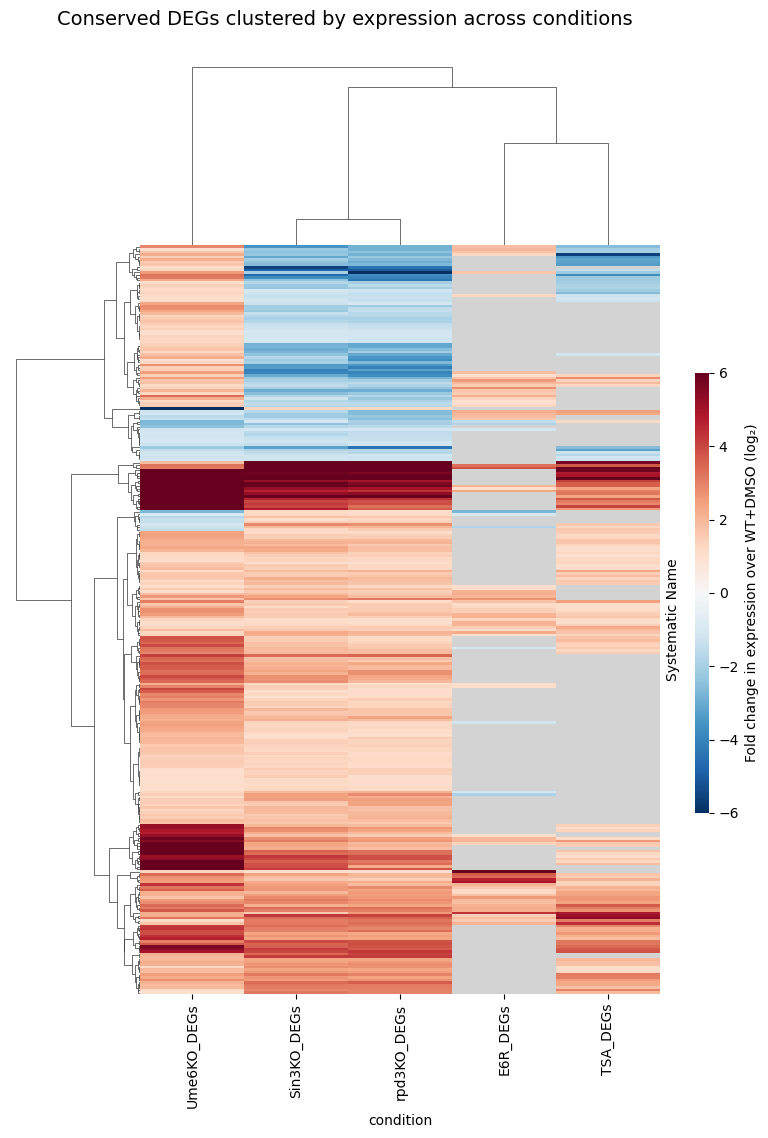

In [5]:
#Step 6: Drop rows with no values at all
heatmap_df.dropna(how='all', inplace=True)


#Step 7: Mask + fill for clustering
nan_mask = heatmap_df.isna()
heatmap_df_clustering = heatmap_df.fillna(0.005)

linkage_rows = linkage(pdist(heatmap_df_clustering, metric='euclidean'), method='ward')
linkage_cols = linkage(pdist(heatmap_df_clustering.T, metric='euclidean'), method='ward')

#Create colormap with grey for masked
cmap = plt.cm.RdBu_r
cmap.set_bad(color='lightgrey')  #Grey for non-DEGs

#Plot clustermap with external colorbar
g = sns.clustermap(
    data=heatmap_df_clustering,
    cmap=cmap,
    vmin=-6, vmax=6,
    mask=nan_mask,
    row_linkage=linkage_rows,
    col_linkage=linkage_cols,
    figsize=(7, 11),
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1, 0.3, 0.02, 0.4),  # (x, y, width, height)
    cbar_kws={'label': 'Fold change in expression over WT+DMSO (log₂)'}
)

#Grey background for missing (non-DEG) values
g.ax_heatmap.set_facecolor('lightgrey')
g.fig.suptitle("Conserved DEGs clustered by expression across conditions", fontsize=14, y=1.03)
plt.show()

1. High proportion of missing values (NaNs) in TSA column
Heatmap only includes genes conserved in all three: rpd3KO, sin3KO & ume6KO. Hence, TSA doesn't share enough DEGs with rpd3KO/Sin3KO— several entries in the TSA column are gray (NaN).

Clustering algorithms like Ward’s method treat missing data by implicitly filling them (often with 0 or a small dummy value like 0.005), which flattens the TSA vector => This makes TSA look more like E6R, which also has fewer shared DEGs in this subset.

2. TSA’s values are less variable (or weaker) 
Even where TSA has values, the profile looks flatter if those log2FoldChanges are low in magnitude. In contrast, rpd3KO/Sin3KO likely show stronger signals. TSA ends up numerically closer to E6R in Euclidean distance, which drives the clustering.

3. Clustering is distance-based
Column clustering uses pairwise distances between full condition vectors (with dummy-filled NaNs). So, despite TSA being a biological subset of rpd3/Sin3KO, if the actual data vectors aren't close enough, clustering will separate them.

Hence: 
- The clustering is statistically valid, but not biologically aligned due to missing data & flattened profiles.
- Our idea of reordering the columns (Sin3KO → rpd3KO → TSA) is justified for better interpretability.

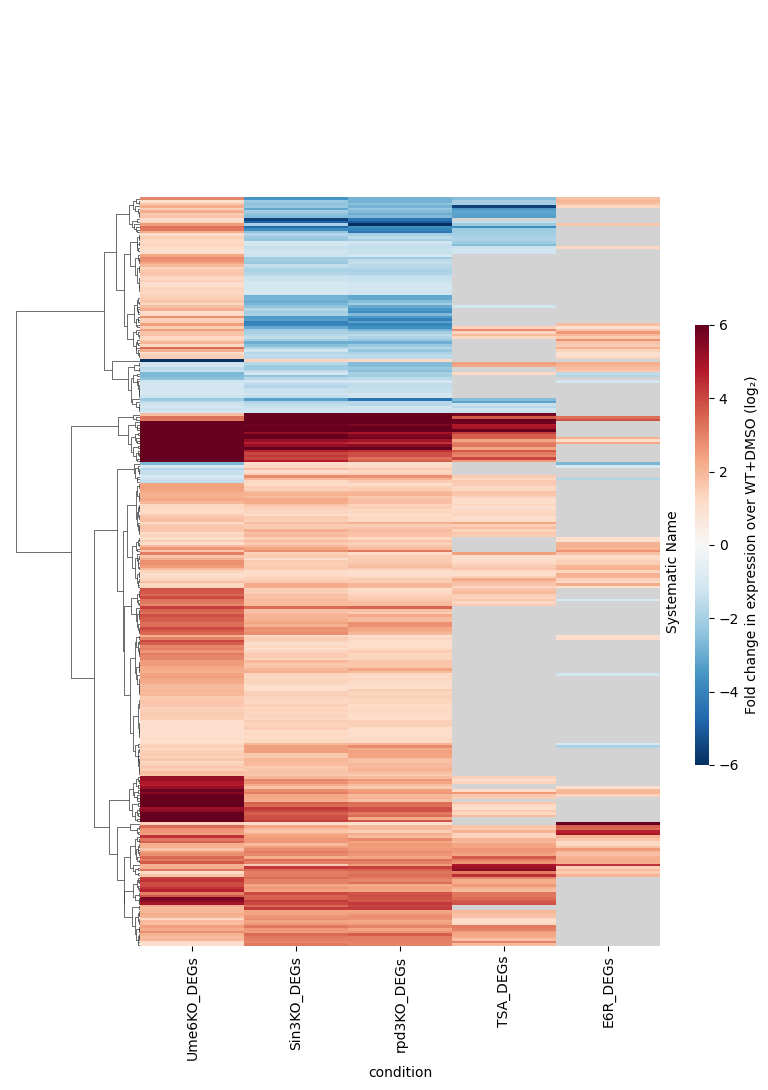

In [6]:
#Desired column order
desired_order = ['Ume6KO_DEGs', 'Sin3KO_DEGs', 'rpd3KO_DEGs', 'TSA_DEGs', 'E6R_DEGs']

#Filter to keep only present columns
available_order = [col for col in desired_order if col in heatmap_df_clustering.columns]

#Reorder heatmap dataframe
heatmap_df_clustering = heatmap_df_clustering[available_order]
nan_mask = nan_mask[available_order]

#Recompute col linkage if needed (optional)
linkage_cols = linkage(pdist(heatmap_df_clustering.T, metric='euclidean'), method='ward')

#Replot clustermap
g = sns.clustermap(
    data=heatmap_df_clustering,
    cmap=cmap,
    vmin=-6, vmax=6,
    mask=nan_mask,
    row_linkage=linkage_rows,
    col_cluster=False,  # Don't cluster columns
    figsize=(7, 11),
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1, 0.3, 0.02, 0.4),
    cbar_kws={'label': 'Fold change in expression over WT+DMSO (log₂)'}
)

g.ax_heatmap.set_facecolor('lightgrey')
#g.savefig("Figure4B_conserved_DEGs_heatmap_30042025.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

## E6R selectively de-represses genes associated with Ume6-bound URS1 motifs.

### Focus on genes Ume6-bound (published ChIP-seq) and/or containing URS1 (MotifMap)  

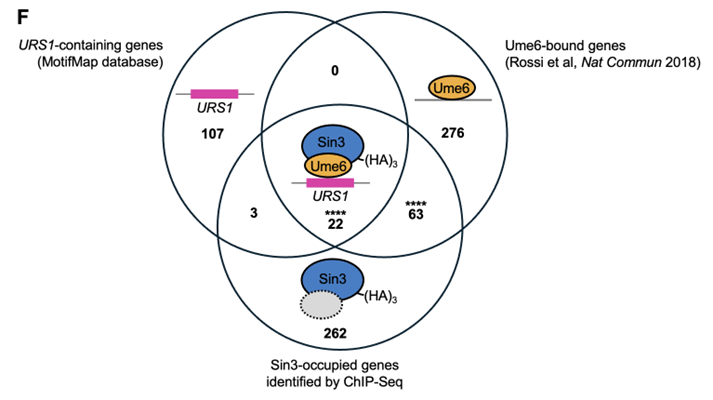

Subset of genes directly regulated by ume6:

- URS1 stands for "Upstream Repression Sequence 1", a specific DNA motif found in the promoter regions of certain genes in yeast.
- Once Ume6 binds URS1, it recruits the Sin3/Rpd3 HDAC complex → leading to histone deacetylation → chromatin compaction → gene repression

In [7]:
#Load Excel with two sheets having the Ume6-bound genes: 
file_path = "Ume6 bound genes and URS1-containing.xlsx"


#Read both sheets, skipping the first two rows
ume6_df = pd.read_excel(file_path, sheet_name='Ume6-bound', skiprows=2)
urs1_df = pd.read_excel(file_path, sheet_name='URS1-containing', skiprows=2)

#Drop any rows where 'Systematic name' is NaN
ume6_genes = ume6_df['Systematic name'].dropna().unique()
urs1_genes = urs1_df['Systematic name'].dropna().unique()

#Find intersection
ume6_set = set(ume6_genes)
urs1_set = set(urs1_genes)

overlap_genes = ume6_set & urs1_set

#Print results
print(f" Total Ume6-bound genes: {len(ume6_set)}")
print(f" Total URS1-containing genes: {len(urs1_set)}")
print(f" Overlapping genes: {len(overlap_genes)}")
print(f" Overlapping gene list:\n{sorted(overlap_genes)}")

 Total Ume6-bound genes: 361
 Total URS1-containing genes: 132
 Overlapping genes: 107
 Overlapping gene list:
['YAL005C', 'YBL064C', 'YBL086C', 'YBR089C-A', 'YBR184W', 'YBR196C-A', 'YBR196C-B', 'YBR256C', 'YBR282W', 'YBR284W', 'YCL024W', 'YCL057W', 'YCR010C', 'YCR061W', 'YDL070W', 'YDL210W', 'YDR014W-A', 'YDR091C', 'YDR285W', 'YDR359C', 'YDR374W-A', 'YDR487C', 'YER044C-A', 'YER130C', 'YER179W', 'YFR017C', 'YGL033W', 'YGL062W', 'YGL184C', 'YGL225W', 'YGL250W', 'YGL251C', 'YGR067C', 'YGR264C', 'YHL024W', 'YHR013C', 'YHR014W', 'YHR124W', 'YHR154W', 'YIL026C', 'YIL031W', 'YIL033C', 'YIL072W', 'YIL073C', 'YJL089W', 'YJL106W', 'YJL153C', 'YJR005C-A', 'YJR092W', 'YJR094W-A', 'YJR121W', 'YKL015W', 'YKL078W', 'YLL030C', 'YLL039C', 'YLL046C', 'YLR024C', 'YLR131C', 'YLR259C', 'YLR263W', 'YLR314C', 'YLR315W', 'YLR394W', 'YLR400W', 'YLR414C', 'YLR417W', 'YLR444C', 'YLR450W', 'YML042W', 'YMR101C', 'YMR133W', 'YMR186W', 'YMR291W', 'YMR306W', 'YNL149C', 'YNL186W', 'YNL196C', 'YNL210W', 'YNL211C', 'YN

In [8]:
#To get the sum of two gene lists — meaning all unique genes present in either set (i.e., the union) 

combined_genes = ume6_set | urs1_set  #Union of both sets
len(combined_genes)

386

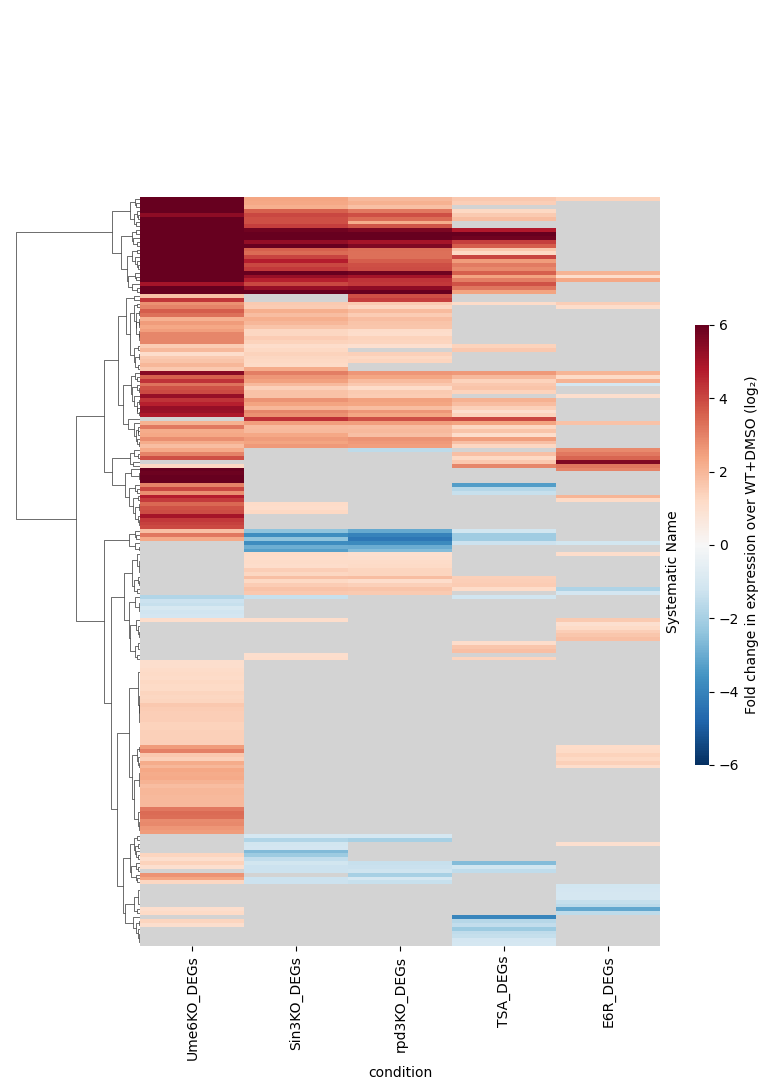

In [9]:
#Subset union of genes (combined_genes) for figure 4B
heatmap_df = all_degs[all_degs['Systematic Name'].isin(combined_genes)].pivot_table(
    index='Systematic Name',
    columns='condition',
    values='log2FoldChange'
)

#Drop rows with all NaNs (no DEG in any condition)
heatmap_df.dropna(how='all', inplace=True)

#Create mask for non-DEGs (NaNs)
nan_mask = heatmap_df.isna()

#Fill NaNs with a small value for clustering
heatmap_df_clustering = heatmap_df.fillna(0.005)

#Desired column order
desired_order = ['Ume6KO_DEGs', 'Sin3KO_DEGs', 'rpd3KO_DEGs', 'TSA_DEGs', 'E6R_DEGs']

#Filter to keep only present columns
available_order = [col for col in desired_order if col in heatmap_df_clustering.columns]

#Reorder heatmap dataframe
heatmap_df_clustering = heatmap_df_clustering[available_order]
nan_mask = nan_mask[available_order]

#Perform hierarchical clustering
linkage_rows = linkage(pdist(heatmap_df_clustering, metric='euclidean'), method='ward')

#Masked data for plotting grey non-DEGs
#masked_data = np.ma.masked_where(nan_mask.values, heatmap_df_clustering.values)

g = sns.clustermap(
    data=heatmap_df_clustering,
    cmap=cmap,
    vmin=-6, vmax=6,
    mask=nan_mask,
    row_linkage=linkage_rows,
    col_cluster=False,  # Don't cluster columns
    figsize=(7, 11),
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1, 0.3, 0.02, 0.4),
    cbar_kws={'label': 'Fold change in expression over WT+DMSO (log₂)'}
)

g.ax_heatmap.set_facecolor('lightgrey')
g.savefig("Fig4B_ume6_urs1_Union386_heatmap_30042025.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [10]:
#All DEGs across all conditions: 
unique_degs = all_degs['Systematic Name'].nunique()
print(f"Total unique DEGs across all conditions: {unique_degs}")

#Use 1795 DEGs for unsupervised clustering 

Total unique DEGs across all conditions: 1795


In [11]:
#Grey for non-DEGs (missing values)

#Redo: Drop rows with all NaNs
#Pivot to wide format
heatmap_df = all_degs.pivot_table(index='Systematic Name', columns='condition', values='log2FoldChange')

#Drop rows with all NaNs (no overlap)
heatmap_df.dropna(how='all', inplace=True)

#Create a mask and replace NaNs with small value (e.g. 0.005)
nan_mask = heatmap_df.isna()

#Replace NaNs with small values for clustering
heatmap_df_clustering = heatmap_df.fillna(0.005)

#Hierarchical clustering
linkage_rows = linkage(pdist(heatmap_df_clustering, metric='euclidean'), method='ward')
linkage_cols = linkage(pdist(heatmap_df_clustering.T, metric='euclidean'), method='ward')

#Mask the data for plotting (masked values become grey if colormap is set accordingly)
masked_data = np.ma.masked_where(nan_mask.values, heatmap_df_clustering.values)

#Create colormap with grey for masked
cmap = plt.cm.RdBu_r
cmap.set_bad(color='lightgrey')  # Grey for non-DEGs

In [12]:
genes_all_degs = set(all_degs['Systematic Name'].unique())
genes_heatmap = set(heatmap_df.index)

#Check if they're equal
print("Same gene set:", genes_all_degs == genes_heatmap)

#To see what differs:
print("Genes in all_degs but not in heatmap_df:", genes_all_degs - genes_heatmap)
print("Genes in heatmap_df but not in all_degs:", genes_heatmap - genes_all_degs)

#gene rows in heatmap_df are identical to the ones in all_degs. 

Same gene set: True
Genes in all_degs but not in heatmap_df: set()
Genes in heatmap_df but not in all_degs: set()


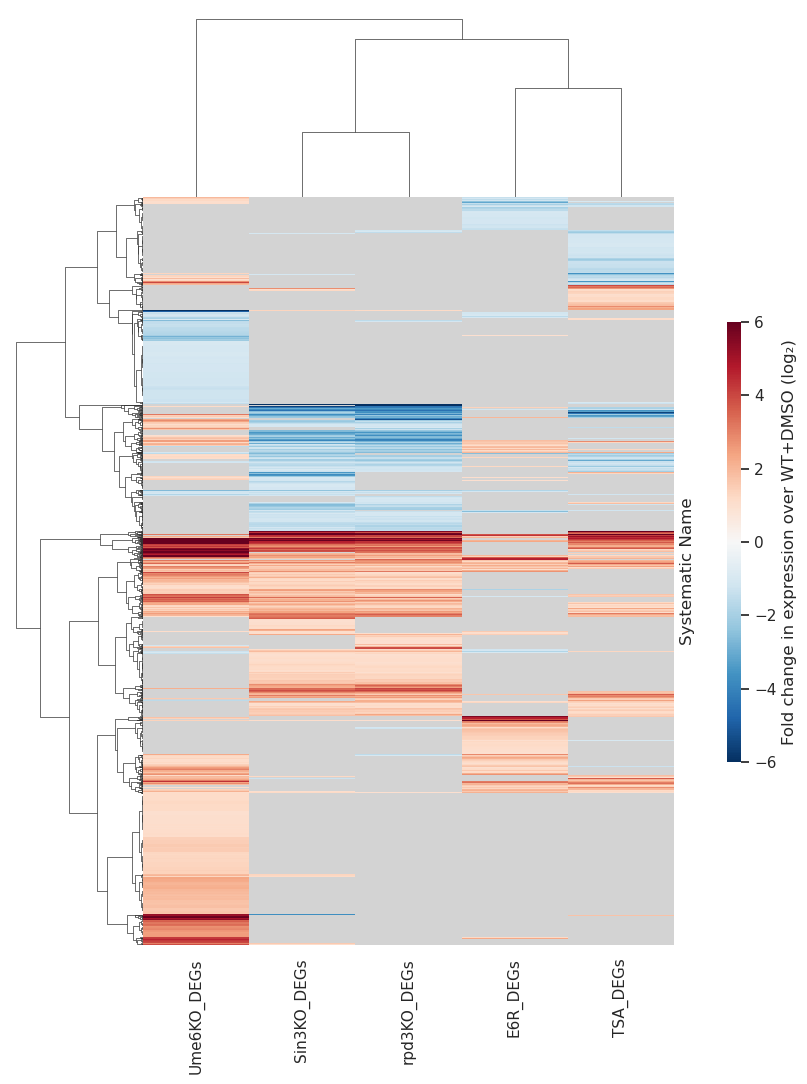

In [13]:
#Plot
sns.set(style='white')

g = sns.clustermap(
    masked_data,
    row_linkage=linkage_rows,
    col_linkage=linkage_cols,
    cmap=cmap,
    center=0,
    vmin=-6,
    vmax=6,
    xticklabels=heatmap_df.columns,
    yticklabels=False,
    figsize=(7, 11),
    cbar_pos=(1.05, 0.3, 0.02, 0.4),  # (x, y, width, height)
    cbar_kws={'label': 'Fold change in expression over WT+DMSO (log₂)'}
)
    
# Apply proper tick labels (optional)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('Systematic Name')

#plt.savefig("FigS5_AllDEGs_heatmap_final_30042025.pdf", dpi=600, bbox_inches='tight')
plt.show()

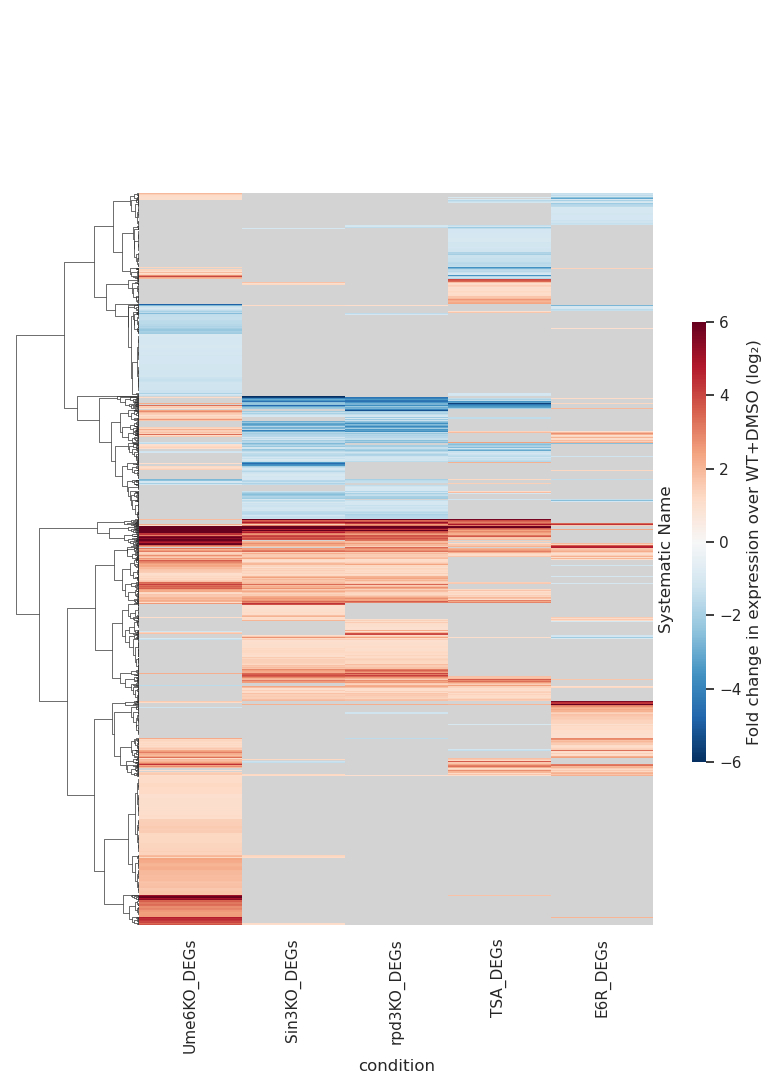

In [14]:
#Redo: Drop rows with all NaNs
#Pivot to wide format
heatmap_df = all_degs.pivot_table(index='Systematic Name', columns='condition', values='log2FoldChange')

#Drop rows with all NaNs (no overlap)
heatmap_df.dropna(how='all', inplace=True)

#Create a mask and replace NaNs with a small value (e.g., 0.005)
nan_mask = heatmap_df.isna()

#Replace NaNs with small values for clustering
heatmap_df_clustering = heatmap_df.fillna(0.005)

#Desired column order
desired_order = ['Ume6KO_DEGs', 'Sin3KO_DEGs', 'rpd3KO_DEGs', 'TSA_DEGs', 'E6R_DEGs']

#Filter to keep only present columns
available_order = [col for col in desired_order if col in heatmap_df_clustering.columns]

#Reorder heatmap dataframe
heatmap_df_clustering = heatmap_df_clustering[available_order]
nan_mask = nan_mask[available_order]

#Perform hierarchical clustering
linkage_rows = linkage(pdist(heatmap_df_clustering, metric='euclidean'), method='ward')

g = sns.clustermap(
    data=heatmap_df_clustering,
    cmap=cmap,
    vmin=-6, vmax=6,
    mask=nan_mask,
    row_linkage=linkage_rows,
    col_cluster=False,  # Don't cluster columns
    figsize=(7, 11),
    xticklabels=True,
    yticklabels=False,
    cbar_pos=(1, 0.3, 0.02, 0.4),
    cbar_kws={'label': 'Fold change in expression over WT+DMSO (log₂)'}
)

g.ax_heatmap.set_facecolor('lightgrey')
g.savefig("FigS5A_AllDEGs_heatmap_30042025.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()